# Python packages required to run the mode

In [1]:
import pygad
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm
from scipy.signal import find_peaks, peak_prominences, peak_widths, savgol_filter
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
import csv
import shutil
import os



In [2]:

txt_file_path = 'C:\\Users\\maril\\Downloads\\HAPKE_MIXING-master\\HAPKE_MIXING-master\\halite_spectra.txt'

csv_file_path = os.path.splitext(txt_file_path)[0] + '.csv'

# Process and write to CSV file
with open(txt_file_path, 'r') as txt_file, open(csv_file_path, 'w', newline='') as csv_file:
    reader = csv.reader(txt_file, delimiter='\t')
    writer = csv.writer(csv_file, delimiter=',')

    next(reader, None)

    for row in reader:
        writer.writerow(row)

print(f'Converted file saved at: {csv_file_path}')


Converted file saved at: C:\Users\maril\Downloads\HAPKE_MIXING-master\HAPKE_MIXING-master\halite_spectra.csv


# Read measured reflectance data (and epsilon)

Please read the measured spectra and if needed average it.
Measured Reflectance should be between 0-1.

If the viewing angle of the sample is not normal, please update the viewing_angle variable in the code block below

The code block below reads the individual spectra of the sample, averages it and plots the same.

The sample hawaii spectra for three spots are provided in the github folder.

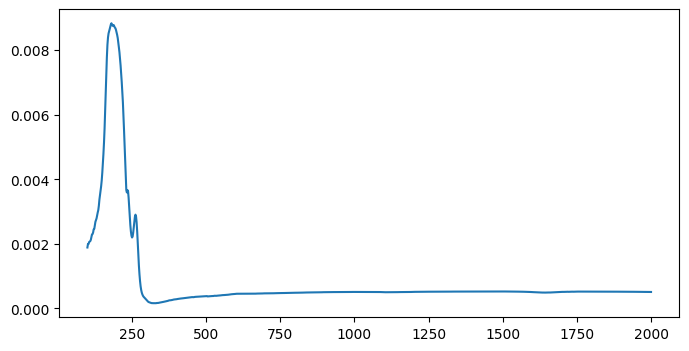

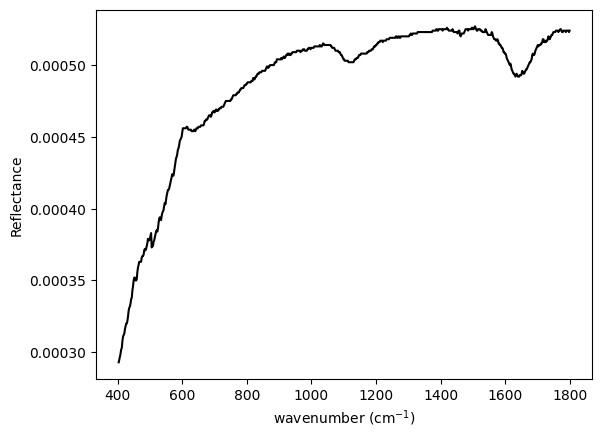

In [3]:
# read data
# data=xlsread('082420_pure_pellet_PARSEC_data'); #original spectra used in the code 

spot1 = np.loadtxt('halite_spectra.csv', delimiter=',')
#spot2 = np.loadtxt('hawaii_glass_spot2.CSV', delimiter=',')
#spot3 = np.loadtxt('hawaii_glass_spot3.CSV', delimiter=',')
viewing_angle = 0

plt.figure(figsize=(8,4))
plt.plot(spot1[:,0], spot1[:,1]/100, label='spot1')
#plt.plot(spot2[:,0], spot2[:,1]/100, label='spot2')
#plt.plot(spot3[:,0], spot3[:,1]/100, label='spot3')
plt.show()


# data = spot1.copy()
data = np.average([spot1], axis=0)

np.savetxt("halite_single_crystal_average.txt",data)

v=data[:,0]
R=data[:,1]/100

#cut out data with wavenumbers < 350 cm-1 and wavenumbers >1600 cm-1
R = R[(v>400) & (v<1800)][1:]
v = v[(v>400) & (v<1800)][1:]


plt.plot(v, R, 'k', label="measured R")
plt.xlabel('wavenumber (cm${^{-1}}$)') 
plt.ylabel("Reflectance")
plt.show()






# Numerical model  - Dispersion and Fresnel

function fresnel_sbu: fresnel model for non-normal incidence which returns modeled reflectance\
function dispersion_model: dispersion_model which returns n and k\
function calculate_rnk: calculate r, n, k using fresnel_sbu and dispersion_model functions

No change is necessary in the code block below for running new sample spectra

In [4]:
def fresnel_sbu(n,k, viewing_angle): #theta = viewing_angledeg
    u1 = np.square(n)-np.square(k)-np.square(np.sin(viewing_angle*math.pi/180))
    u2 = np.sqrt(np.square(u1) + (4*np.multiply(np.square(n),np.square(k))))
    u = np.sqrt((u1+u2)/2)

    v = np.sqrt((-u1 + u2)/2)


    R_par_num = np.square(np.cos(viewing_angle*math.pi/180)-u)+ np.square(v)
    R_par_denom = np.square(np.cos(viewing_angle*math.pi/180)+u)+ np.square(v)
    R_par = np.divide(R_par_num,R_par_denom)

    R_perp_num = np.square(((np.square(n)-np.square(k))*np.cos(viewing_angle*math.pi/180))-u) + np.square((2*np.cos(viewing_angle*math.pi/180)*np.multiply(n,k))-v)
    R_perp_denom = np.square(((np.square(n)-np.square(k))*np.cos(viewing_angle*math.pi/180))+u) + np.square((2*np.cos(viewing_angle*math.pi/180)*np.multiply(n,k))+v)
    R_perp = np.divide(R_perp_num,R_perp_denom)

    R_sbu = (R_perp+R_par)/2

    return R_sbu


def dispersion_model(nu,gamm,fourpr,epsil,v):
# dispersion_model: Spitzer and Kleinman dispersion model
# v: frequency list
# gamm: damping parameter
# fourpr: bandwidth parameter
# epsil: bulk dialectric constant

    # make v be Mx1
    v = v[:,None]

    # make nu, fourpr, gamm be 1xN 
    nu = nu[:,None].T
    fourpr = fourpr[:,None].T 
    gamm = gamm[:,None].T 

    v = np.tile(v,(1,len(nu)))
    nu = np.tile(nu,(len(v),1))
    fourpr = np.tile(fourpr,(len(v),1))
    gamm = np.tile(gamm,(len(v),1))

    a = np.square(nu)-np.square(v)
    denom = np.square(a) + np.square(nu * gamm * v)
    alpha = np.divide((fourpr*np.square(nu)*a),denom)
    bet = np.divide(((fourpr/2) * np.square(nu) * gamm * nu * v),denom)
    theta = epsil + np.sum(alpha,axis=1)
    phi = np.sum(bet,axis=1)
    a2 = np.sqrt(np.square(theta) + (4*np.square(phi)))
    n = np.sqrt((theta+a2)/2)
    k = np.divide(phi,n)

    return n, k

def calculate_rnk(coef,v, viewing_angle):
# disp_model_wrap: wrapper for dispersion model

    N = int((len(coef)-1)/3)
#     if isinstance(N, int): 
#         print('ERROR: disp_model_wrap_sbu: bad length for coefficient list!')
    
    nu = coef[0:N]
    gamm = coef[N:N+N]
    fourpr = coef[N+N:N+N+N]
    epsil = coef[N+N+N]

    n,k = dispersion_model(nu,gamm,fourpr,epsil,v)
    r = fresnel_sbu(n,k, viewing_angle)

    return r,n,k




# calculate initital parameters using genetic algorithm

## gene space and parameters for pygad

The code block below plots the measured reflectance and its second derivative in two different plots. Bokeh is used to plot in this particular codeblock as it helps us to extract the exact wavenumber position and its index of the boundaries (end-points) of 6 spectral ranges

In [5]:

output_notebook()

df = {'wavelength':v,
     'reflectance':R,
     'sav_gol_R':savgol_filter(R, 21,3),
     'sav_gol_R_diff':savgol_filter(R,21,3, deriv=2)}

source = ColumnDataSource(df)
p = figure(width=500, height=300, title="measured reflectance", x_axis_label="wavenumber", y_axis_label="reflectance")
p.line('wavelength','reflectance', source = source, legend_label="R_measured", line_width=1, color='black')
p.line('wavelength','sav_gol_R', source = source, legend_label="R_smooth", line_width=2, color='red')

p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('v','@wavelength{0.000}'),
    ('R', '@reflectance'),
    ("index", "$index")
], 
    formatters={
        'v': 'printf',
        'R' : 'printf',
    }))

show(p)


p = figure(width=500, height=300, title="Smoothed Reflectance 1st derivative", x_axis_label="wavenumber", y_axis_label="reflectance")
p.line('wavelength','sav_gol_R_diff', source = source, legend_label="R_smooth_diff", line_width=1, color='red')


p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('v','@wavelength{0.000}'),
    ('R', '@reflectance'),
    ("index", "$index")
], 
    formatters={
        'v': 'printf',
        'R' : 'printf',
    }))

show(p)

R_smoothed = savgol_filter(R, 21,3) 



Loading BokehJS ...

In [6]:

# Apply Savitzky-Golay filter for smoothing and to find the second derivative
R_smooth = savgol_filter(R, 21, 3)  # Smoothed reflectance
R_smooth_diff2 = savgol_filter(R, 21, 3, deriv=2)  # Second derivative
R_smooth_diff3 = savgol_filter(R, 21, 3, deriv=3)  # Third derivative

# Finding zero crossings of the third derivative (regime changes)
epsilon = 0.001 
zero_crossings = np.where(np.diff(np.sign(R_smooth_diff3) < epsilon))[0]  # Indices where sign changes

# Data preparation for Bokeh
df = {
    'wavelength': v,
    'reflectance': R,
    'sav_gol_R': R_smooth,
    'sav_gol_R_diff': R_smooth_diff2,
    'zero_crossings': v[zero_crossings]
}

source = ColumnDataSource(df)

# Plotting the smoothed reflectance and its second derivative
p = figure(width=500, height=300, title="Measured Reflectance", x_axis_label="Wavenumber", y_axis_label="Reflectance")
p.line('wavelength', 'reflectance', source=source, legend_label="R_measured", line_width=1, color='black')
p.line('wavelength', 'sav_gol_R', source=source, legend_label="R_smooth", line_width=2, color='red')
p.circle('zero_crossings', [np.interp(z, v, R_smooth) for z in v[zero_crossings]], size=8, color='green', legend_label="Regime Change")

p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('Wavelength', '@wavelength{0.000}'),
    ('Reflectance', '@reflectance{0.000}'),
    ('Smoothed', '@sav_gol_R{0.000}'),
    ("Second Derivative", "@sav_gol_R_diff{0.000}")
]))

show(p)

# Plot for the second derivative separately
p_diff = figure(width=500, height=300, title="Smoothed Reflectance 2nd Derivative", x_axis_label="Wavenumber", y_axis_label="2nd Derivative")
p_diff.line('wavelength', 'sav_gol_R_diff', source=source, legend_label="R_smooth_diff", line_width=2, color='red')
p_diff.circle('zero_crossings', [0]*len(zero_crossings), size=8, color='green', legend_label="Zero Crossings")

p_diff.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('Wavelength', '@wavelength{0.000}'),
    ('Second Derivative', "@sav_gol_R_diff{0.000}")
]))

show(p_diff)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='zero_crossings' [no close matches] {renderer: GlyphRenderer(id='p1175', ...)}


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : x='zero_crossings' [no close matches] {renderer: GlyphRenderer(id='p1235', ...)}


In [9]:
import numpy as np
from scipy.signal import savgol_filter

# Applying Savitzky-Golay filter for smoothing and for the first derivative
R_smooth = savgol_filter(R, 21, 3)  # Smoothed Reflectance
R_smooth_diff = savgol_filter(R, 21, 3, deriv=1)  # 1st derivative of the smoothed Reflectance
R_smooth_diff2 = savgol_filter(R, 21, 3, deriv=2)  # 2nd derivative of the smoothed Reflectance

# Printing the 2nd derivative for visualization
#R_smooth_diff2

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool

# Ensuring Bokeh plots are displayed within the notebook
output_notebook()

# Creating a DataFrame-like structure for Bokeh plotting
df = {
    'wavelength': v,
    'sav_gol_R_diff2': R_smooth_diff2,  # Using the calculated 2nd derivative
}

source = ColumnDataSource(df)

# Creating a new figure for the 2nd derivative of the smoothed reflectance
p = figure(width=500, height=300, title="Smoothed Reflectance 2nd Derivative", x_axis_label="Wavelength", y_axis_label="2nd Derivative of Reflectance")

# Adding a line plot for the 2nd derivative
p.line('wavelength', 'sav_gol_R_diff2', source=source, legend_label="R_smooth_diff2", line_width=2, color='blue')

# Adding hover tool for better visualization
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('Wavelength', '@wavelength{0.000}'),
    ('2nd Deriv. Reflectance', '@sav_gol_R_diff2')
], formatters={
    '@wavelength': 'printf',
    '@sav_gol_R_diff2': 'printf',
}))

# Displaying the plot
show(p)

Loading BokehJS ...

The range values for R1 to R6 in the spectral_range variable is extracted using the bokeh plot above. Please move-over the spectral plot to see the exact regions of boundaries of spectral ranges used in this model.

In [10]:
# spectra_range = {'R1': range(33), 'R2': range(32,108), 'R3':range(107, 226), 'R4':range(225, len(v))}

spectra_range = {'R1': range(25), 'R2': range(38,111), 'R3':range(110, 164), 'R4':range(164, 190), 'R5':range(190, 223), 'R6': range(225, len(v))}
                

# Functions for Genetic Algorithm routine

function fitness_func: calculates the fitness value between measured and modelled spectra. The function returns a fitness value in the range of 0-100. Higher the fitness value better is the fitting.

function chisq: calculates the chi-sq value between the measured and the modelled spectra. Lower the chi-sq value better is the fitting

function ga_optical_constants: Take gene_space as input and returns the ga_instance which has the information for the best fit solutions. In our study, we wrote a user defined parent_selection_func which takes all fitness value of all the parents in each GA run and sorts the fitness value from highest to lowest and selects the parents for which the difference in neighbouring oscillator frequencies (osci_diff) for all oscillators for that parent is > 10 cm-1. This parent_selection_func therefore allows us to avoid the parents whose oscillators are grouped together to a close frequencies. 

function func_lsq_R: is used in the curve_fit function in the next code block. This function acts as a objective function in the non-linear least square routine "curve_fit"

The only change that can be done in the codeblock below is varying the value for the if condition "if np.all(np.abs(osci_diff) > 10):" from 10 to a higher value or lower value depending on the nature of the spectra being studied. Otherwise, the rest of the code in the codeblock is untouched. 




In [11]:
def fitness_func(ga_instance, solution, solution_idx):
    global v
    global R_smoothed
    
    r, n, k = calculate_rnk(solution, v, viewing_angle)
    
    fitness = (1 - chisq(r, R_smoothed)) * 100 # calculating euclidean distance
    
    return fitness

def chisq(modelled, measured):
    return np.round(np.sum(np.square(modelled-measured)/measured),3)

        
def ga_optical_constants(gene_space): 
    def on_generation_progress(ga):
#         print("Generation", ga.generations_completed)
#         print("Generation shape", ga.population.shape)
#         print(ga.population)
        pbar.update(1)
            

    def parent_selection_func(fitness, num_parents, ga_instance):
        # Sorting the fitness values in descending order and getting the indices
        fitness_sorted = np.argsort(fitness)[::-1]

        oscillators_num = int((ga_instance.population.shape[1] - 1) / 3)

        parents = np.empty((num_parents, ga_instance.population.shape[1]))
        
        parent_num = 0
        for fs in fitness_sorted:
            osci_diff = np.ediff1d(ga_instance.population[fs, :oscillators_num])
            
            if parent_num < num_parents:
                if np.all(np.abs(osci_diff) > 10):
                    parents[parent_num, :] = ga_instance.population[fs, :].copy()
                    parent_num += 1
            else:
                break

        # Ensure that the indices of the selected parents are returned as a NumPy ndarray
        selected_parents_indices = np.array(fitness_sorted[:num_parents])

        return parents, selected_parents_indices

            
    num_generations=10000
    sol_per_pop=100
    num_parents_mating=10
    crossover_probability = 0.15
    mutation_percent_genes=(3,2)

    
    with tqdm.tqdm(total=num_generations) as pbar:
        ga_instance = pygad.GA(fitness_func=fitness_func,
                               num_generations=num_generations,
                               sol_per_pop=sol_per_pop,
                               num_genes=len(gene_space),
                               num_parents_mating=num_parents_mating,
                               gene_space = gene_space,
                               gene_type=float,
#                                parent_selection_type='sss',
                              parent_selection_type=parent_selection_func,
                               crossover_type='two_points', 
                               crossover_probability = crossover_probability,
                               mutation_type='adaptive', 
                              mutation_percent_genes=mutation_percent_genes,
                              save_best_solutions=True,
                              save_solutions=True,
                              suppress_warnings=True,
                              allow_duplicate_genes=False,
                               stop_criteria="saturate_100",
                              on_generation=on_generation_progress)

        ga_instance.run() 

    return ga_instance

def func_lsq_R(v, *ga_oscillation_parameters):
# disp_model_wrap: wrapper for dispersion model

    ga_oscillation_parameters = np.array(ga_oscillation_parameters)

    N = int((len(ga_oscillation_parameters)-1)/3)

    nu = ga_oscillation_parameters[0:N]
    gamm = ga_oscillation_parameters[N:N+N]
    fourpr = ga_oscillation_parameters[N+N:N+N+N]
    epsil = ga_oscillation_parameters[N+N+N]

    n,k = dispersion_model(nu,gamm,fourpr,epsil,v)
    r = fresnel_sbu(n,k, viewing_angle)

    return r


## run Genetic Algorithm

It is the final part of the algorithm which first runs the GA routine and then passes the GA found oscillators to the non-linear least square routine "curve_fit". The algorithm starts with assuming two oscillators in the entire spectral range. GA runs for this assumption and finds those oscillators and its parameters. These parameters are then passed to "curve_fit" routine to optimize their values. This modelled spectra is then inspected for its chi_sq value for each spectral range and for where the regions chi_sq are not achieved, new oscillator are assigned to add to those spectral regions and the GA-LSQ routine repeats.  This approach runs iteratively until the chi-sq value for all the spectral regions are reached or the total number of oscillators allowed for the spectra is achieved. 

The inputs that can be altered for the new samples are:

Maximum number of oscillators allowed per spectral range (R1 to R6):
max_num_oscillators_R1,max_num_oscillators_R2, max_num_oscillators_R3, max_num_oscillators_R4, max_num_oscillators_R5, max_num_oscillators_R6 

Chi square val to be achieved for each spectral range R1 to R6:
The values can be adjusted in the if statement for 
chi_sq_val_R1, chi_sq_val_R2,chi_sq_val_R3,chi_sq_val_R4,chi_sq_val_R5,chi_sq_val_R6


The codeblock below saves the results for all runs in three different folders 'best_solution_fitness', 'optical_constants', 'oscillation_params'. 

  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|▏         | 138/10000 [00:09<11:45, 13.97it/s]


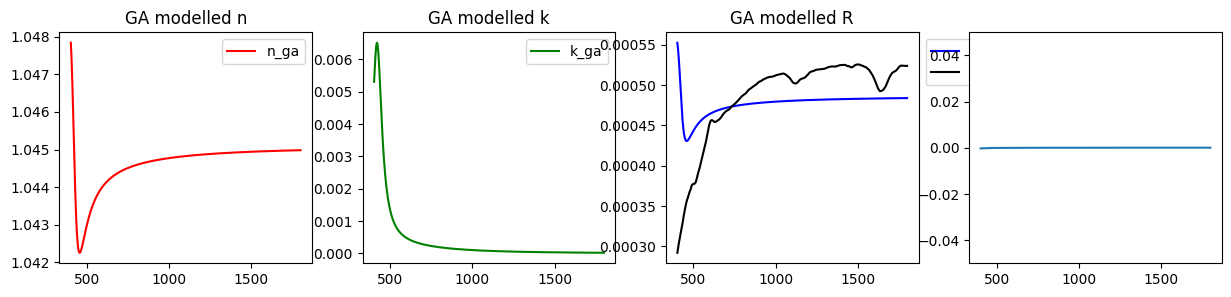

446.5262424000419	422.17398723018107	1.7766812027659438	0.1684860185203081	0.0014061587541966958	0.0021493933518403896	1.0921899399356771
Fitness value of the best solution = 99.6
Best fitness value reached after 38 generations.
Chi-square goodness of overall fitness is  0.004
Chi-square goodness of R1 fitness is  0.003
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.001


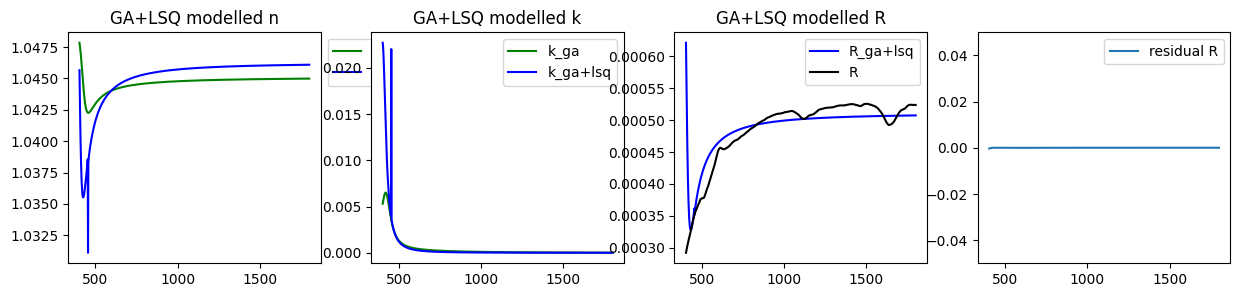

Chi-square goodness of fitness is  0.001
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


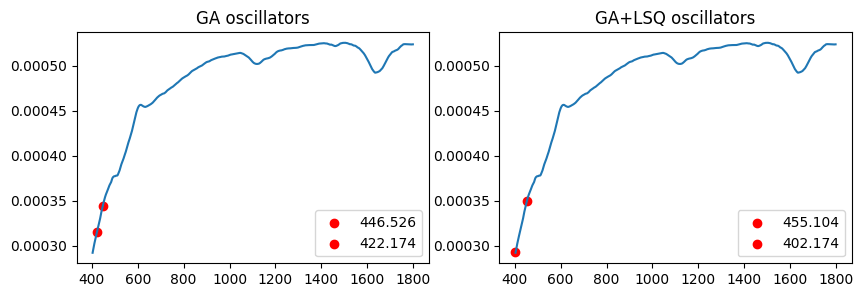

  2%|▏         | 198/10000 [00:14<12:11, 13.40it/s]


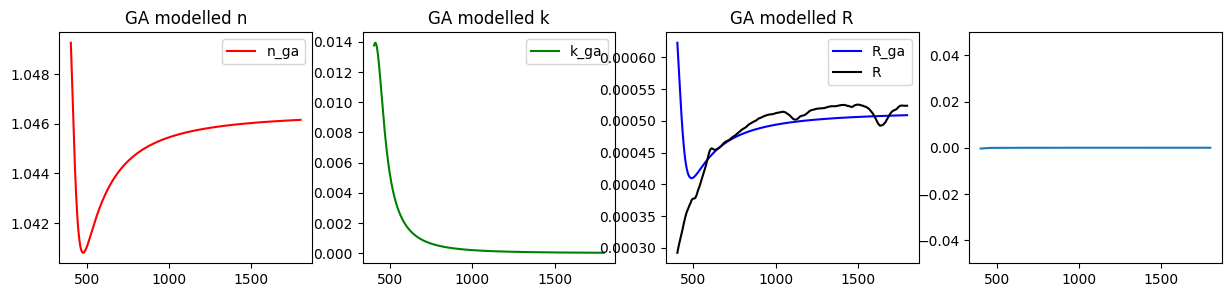

414.7076780479347	455.06940853963414	0.30379837972702184	0.7624309644245739	0.008073606349810136	0.0018339414702537304	1.0950199168566845
Fitness value of the best solution = 99.6
Best fitness value reached after 98 generations.
Chi-square goodness of overall fitness is  0.004
Chi-square goodness of R1 fitness is  0.004
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


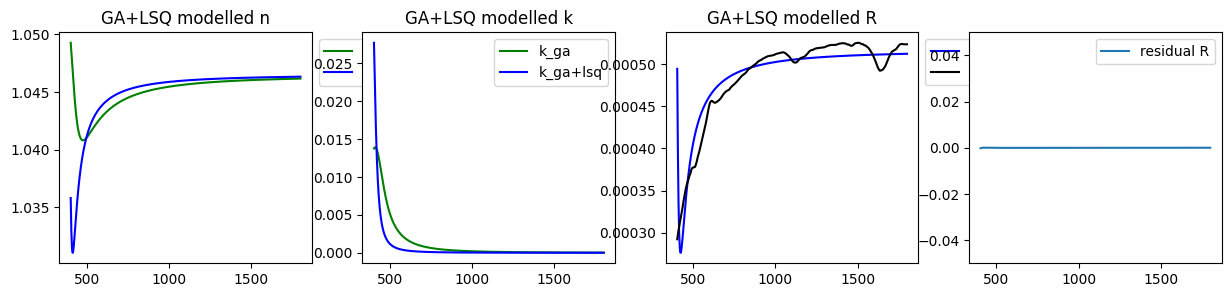

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


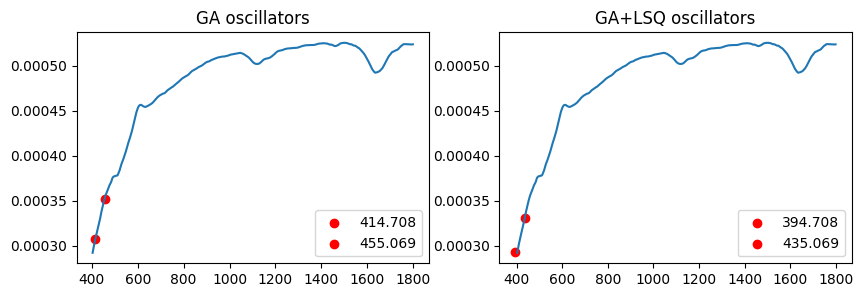

  2%|▏         | 212/10000 [00:16<12:55, 12.63it/s]


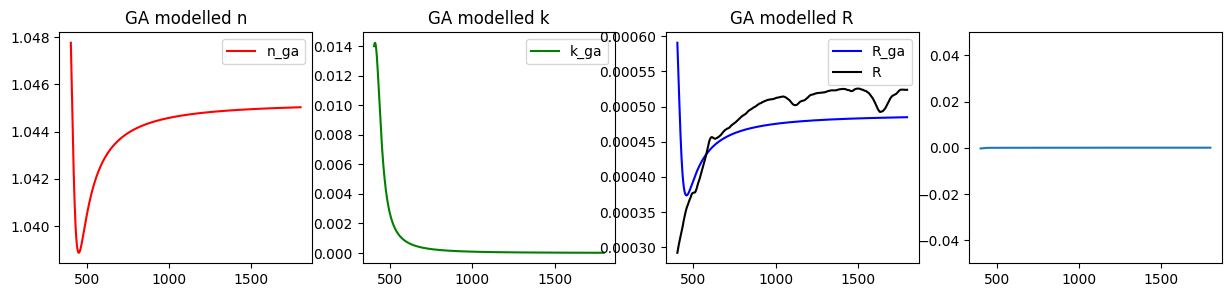

410.43358078957027	448.13718894108086	0.2067254395626248	1.1803507865499556	0.006043565491217429	0.0005030784195330096	1.0924479144457855
Fitness value of the best solution = 99.7
Best fitness value reached after 112 generations.
Chi-square goodness of overall fitness is  0.003
Chi-square goodness of R1 fitness is  0.002
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.001


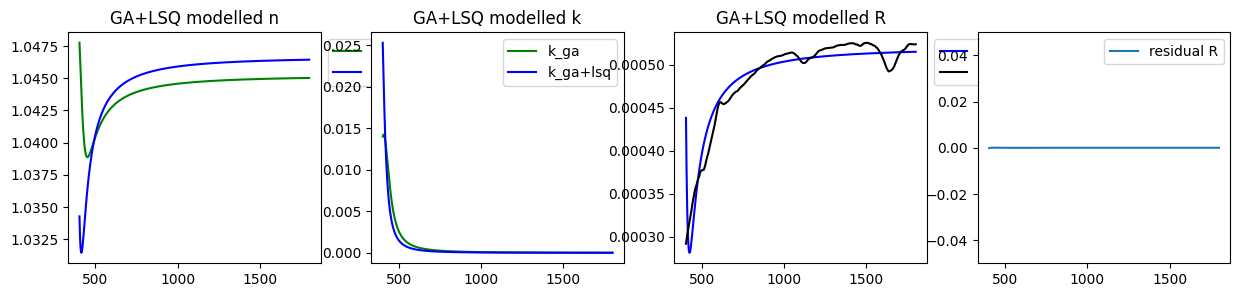

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


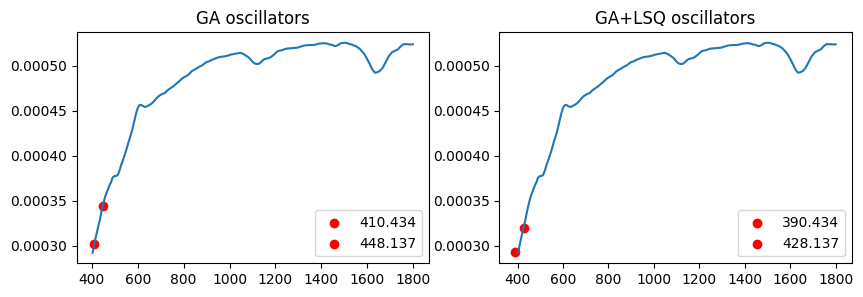

  2%|▏         | 174/10000 [00:13<12:20, 13.28it/s]


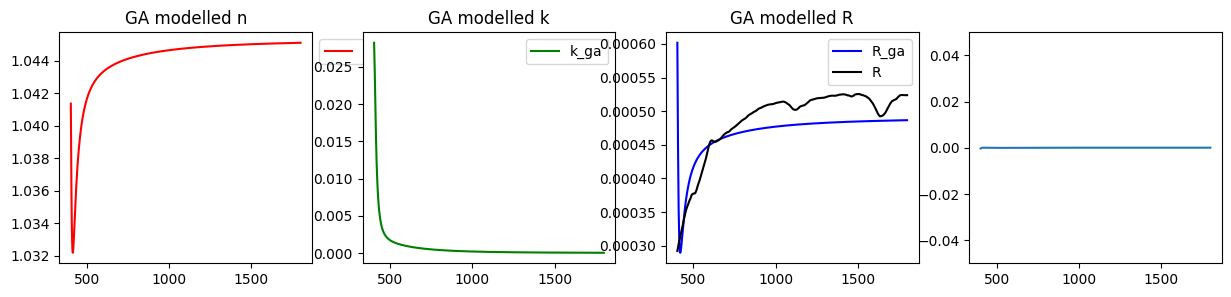

400.6175785819504	439.73504934553574	0.07113900205949286	1.2336416341351166	0.004100331116471567	0.003581567069947278	1.0926818602682704
Fitness value of the best solution = 99.8
Best fitness value reached after 74 generations.
Chi-square goodness of overall fitness is  0.002
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.001


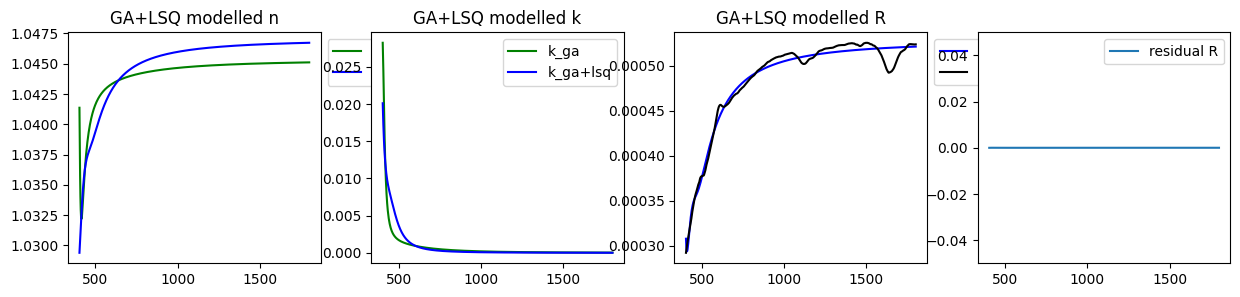

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


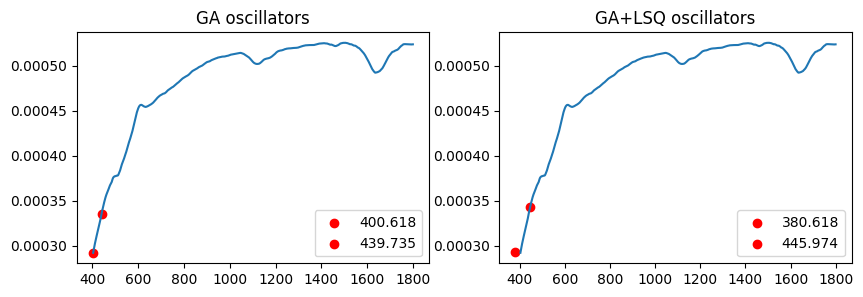

  1%|▏         | 125/10000 [00:08<10:54, 15.08it/s]


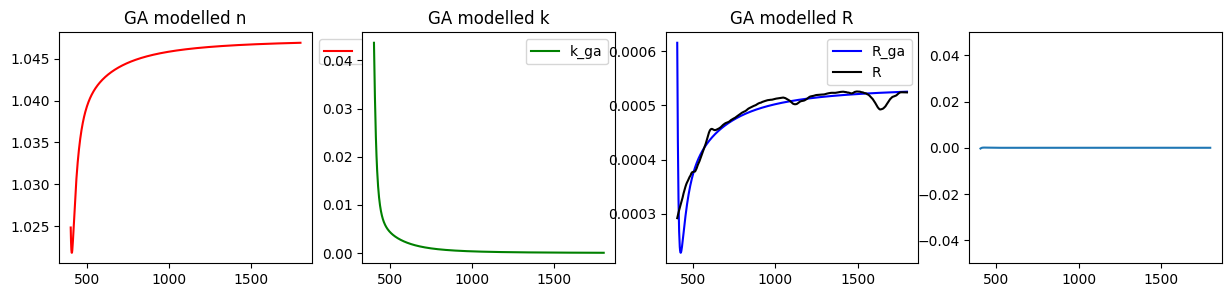

392.54882761159166	449.71654915234757	0.08530121302066074	0.8643019673431556	0.00988514293702547	0.006505185826372717	1.0969188299785548
Fitness value of the best solution = 99.9
Best fitness value reached after 25 generations.
Chi-square goodness of overall fitness is  0.001
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


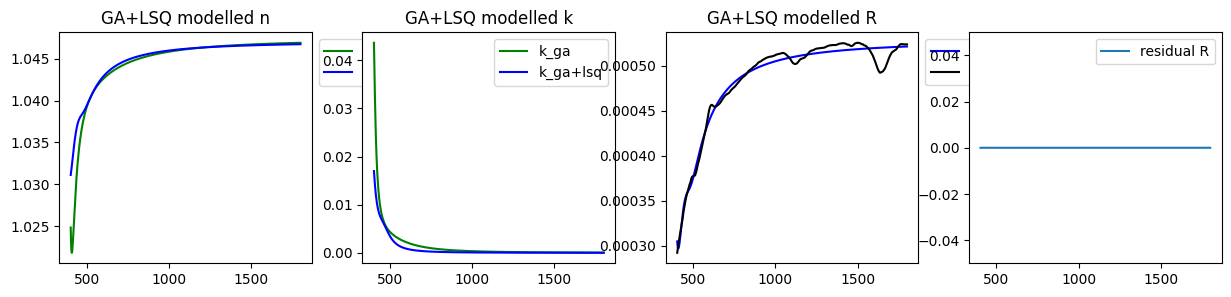

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


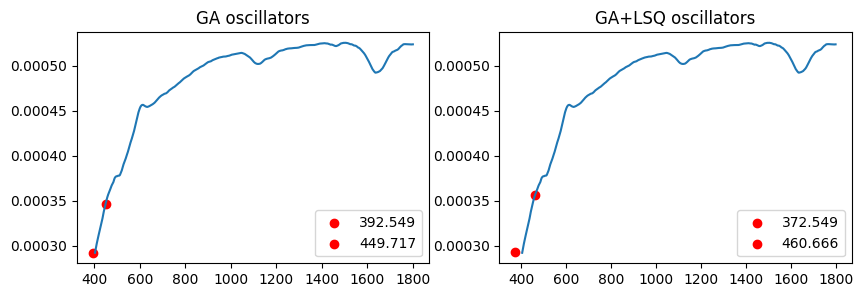

  2%|▏         | 225/10000 [00:18<13:17, 12.26it/s]


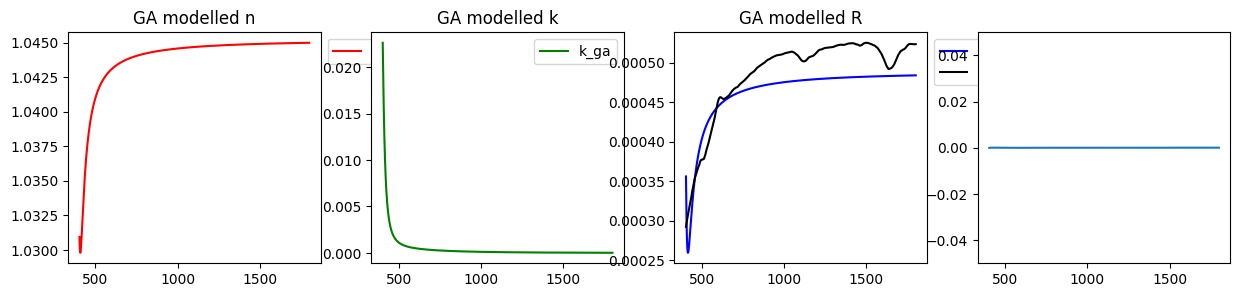

392.24577373950524	445.49860807976313	0.08181380950286976	1.6924778471806456	0.0055083173342134195	0.0017854112732396121	1.0924001421178333
Fitness value of the best solution = 99.9
Best fitness value reached after 125 generations.
Chi-square goodness of overall fitness is  0.001
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.001


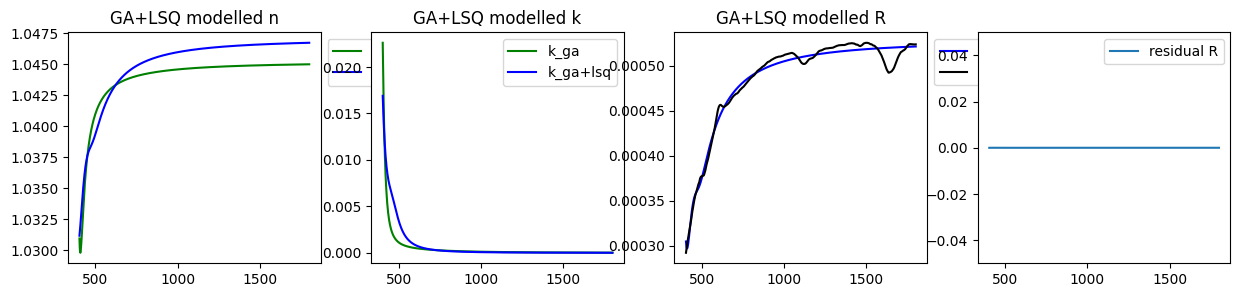

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


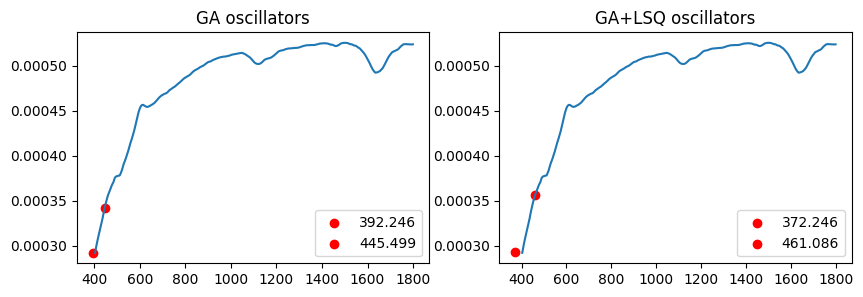

  2%|▏         | 215/10000 [00:17<13:04, 12.47it/s]


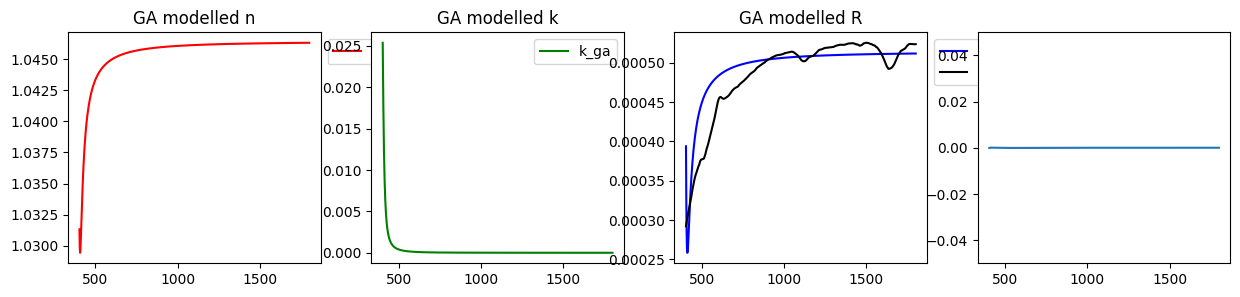

396.7200445542044	452.9767572040954	0.05156797815475023	0.4158327429786608	0.0037633410530444333	8.006630404566728e-05	1.094939724505721
Fitness value of the best solution = 99.9
Best fitness value reached after 115 generations.
Chi-square goodness of overall fitness is  0.001
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.001
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


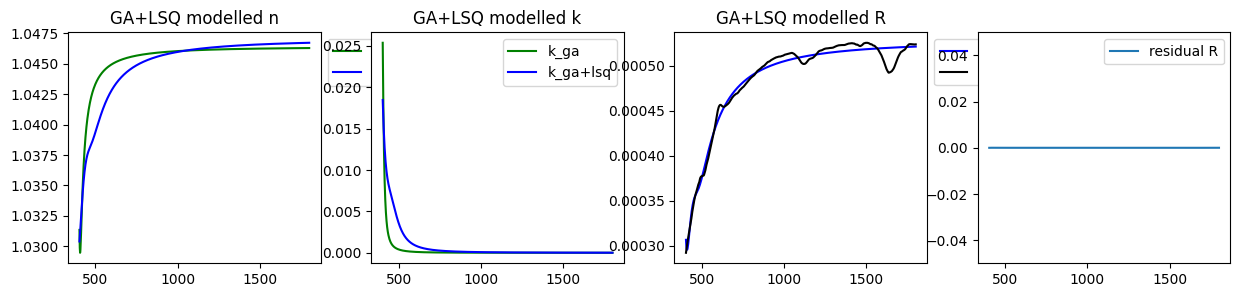

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


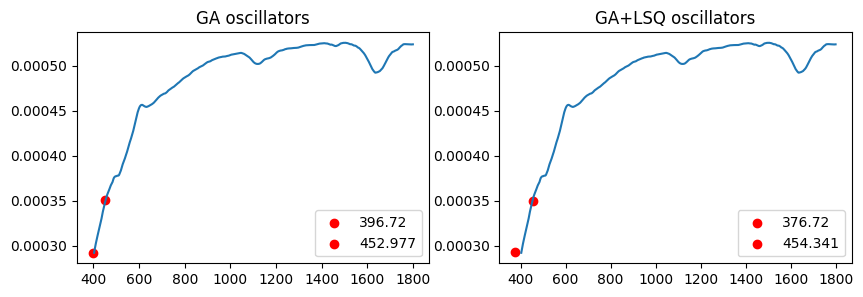

  2%|▏         | 162/10000 [00:11<11:49, 13.86it/s]


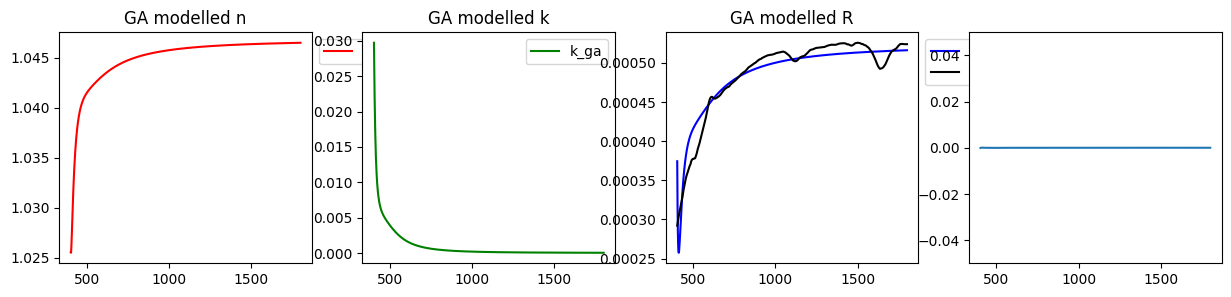

393.0073602285692	456.7626077479455	0.05488592420556371	0.5503273540576652	0.0054909090216281875	0.004768905282376501	1.0957344385174608
Fitness value of the best solution = 100.0
Best fitness value reached after 62 generations.
Chi-square goodness of overall fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


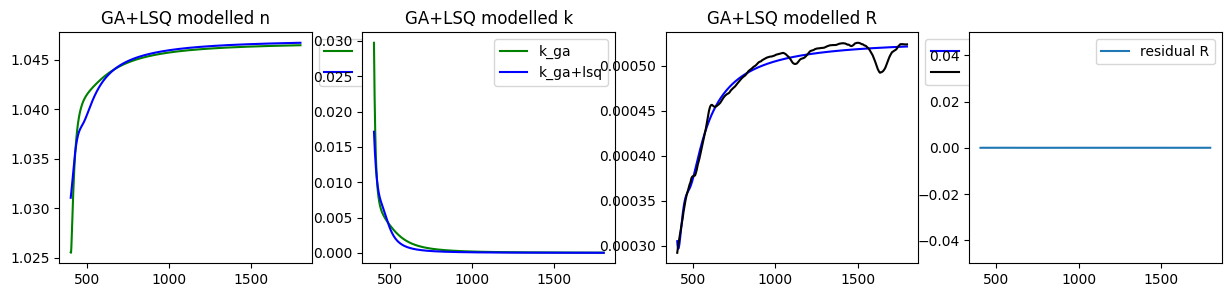

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


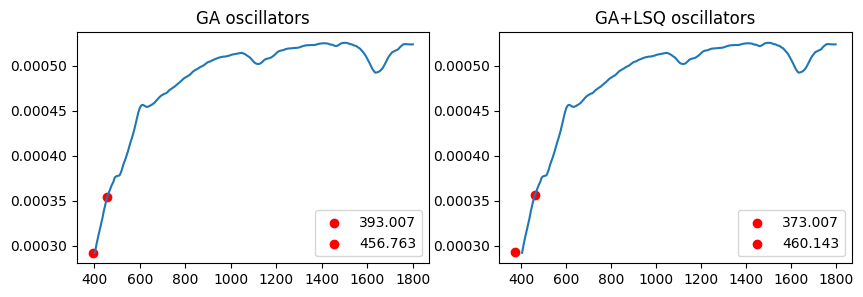

  1%|▏         | 131/10000 [00:08<11:06, 14.81it/s]


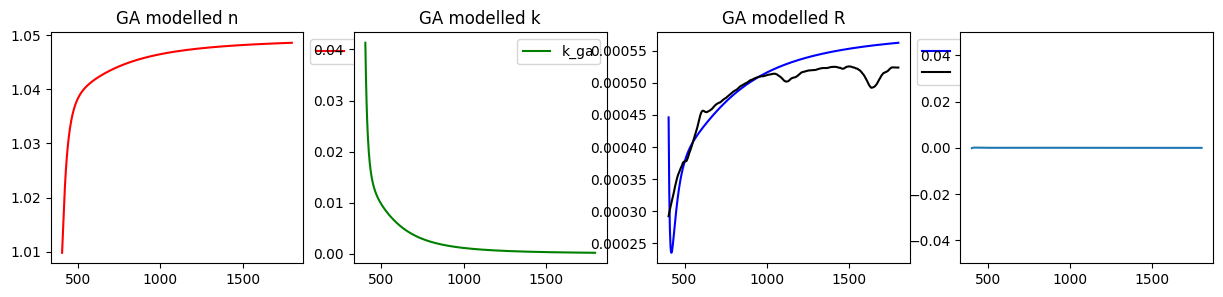

383.07500307903933	448.1944166753691	0.07120184643637906	1.0182727344493592	0.01402893359338031	0.020862895477188337	1.101476407258613
Fitness value of the best solution = 99.9
Best fitness value reached after 31 generations.
Chi-square goodness of overall fitness is  0.001
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.001


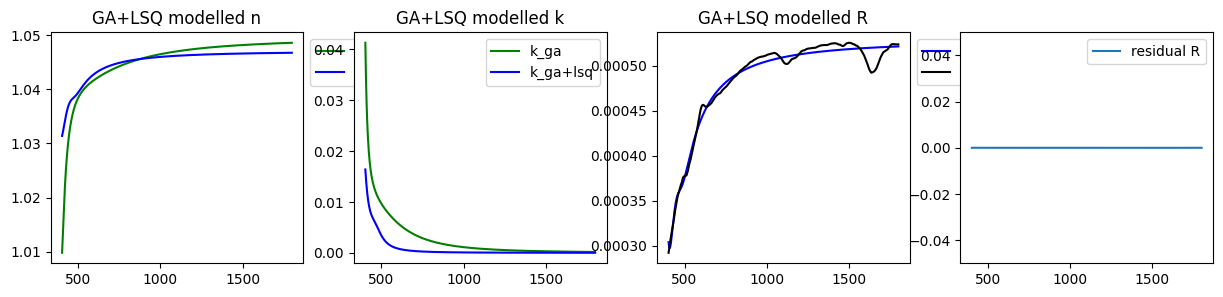

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


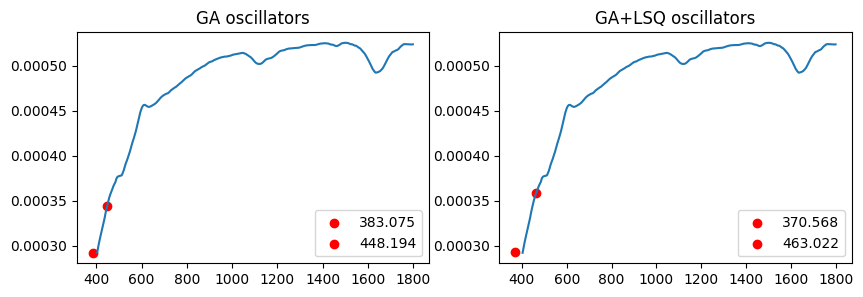

  2%|▏         | 173/10000 [00:12<11:44, 13.94it/s]


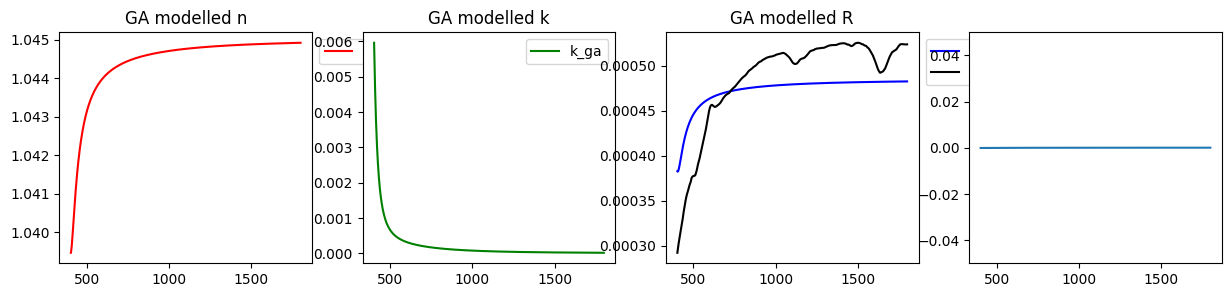

379.72129550068416	452.26555678274383	0.11918814250962328	1.6228893800672053	0.00296586690091849	0.0010136671818234966	1.0920617151968808
Fitness value of the best solution = 99.8
Best fitness value reached after 73 generations.
Chi-square goodness of overall fitness is  0.002
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.001
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.001


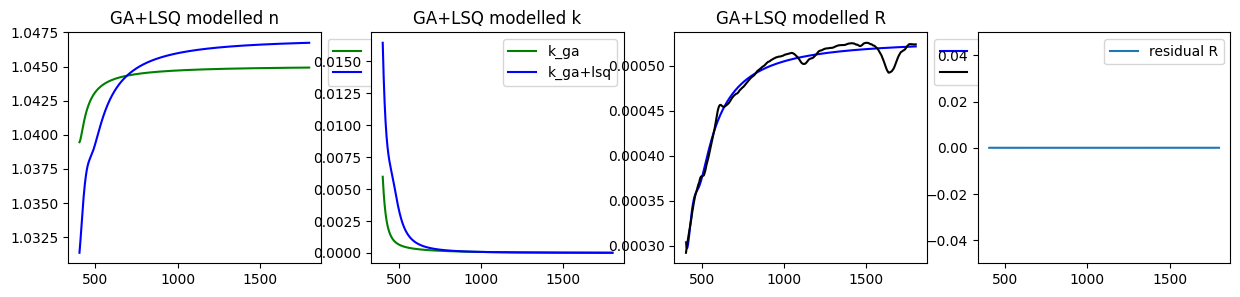

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


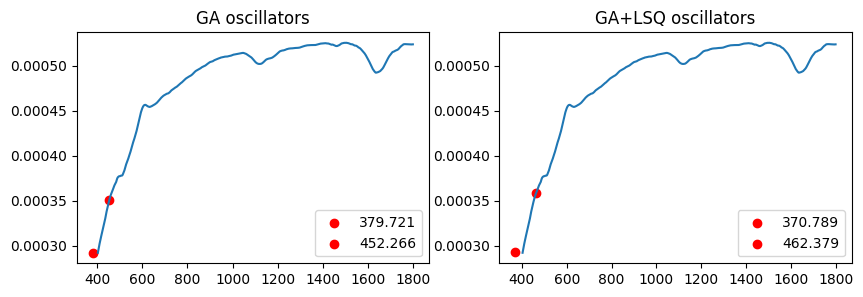

  3%|▎         | 276/10000 [00:25<14:50, 10.92it/s]


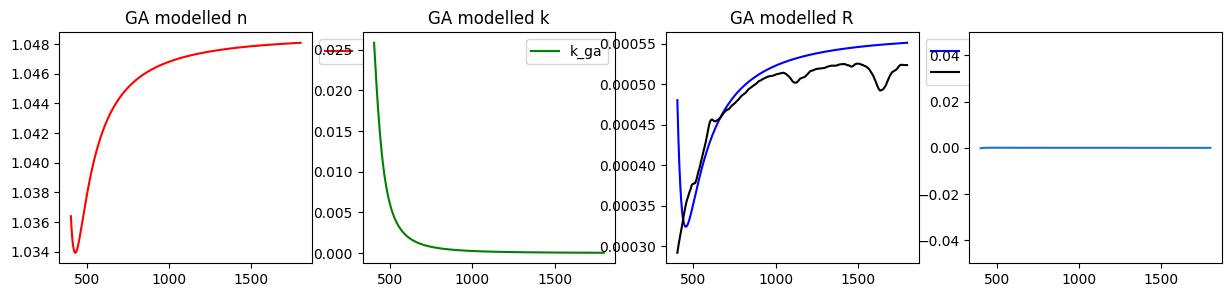

371.9610822164699	458.6732063174846	0.32993638935753666	0.5420905261473021	0.02369187745763135	5.958610832301758e-06	1.0995399691720331
Fitness value of the best solution = 99.9
Best fitness value reached after 176 generations.
Chi-square goodness of overall fitness is  0.001
Chi-square goodness of R1 fitness is  0.001
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.001


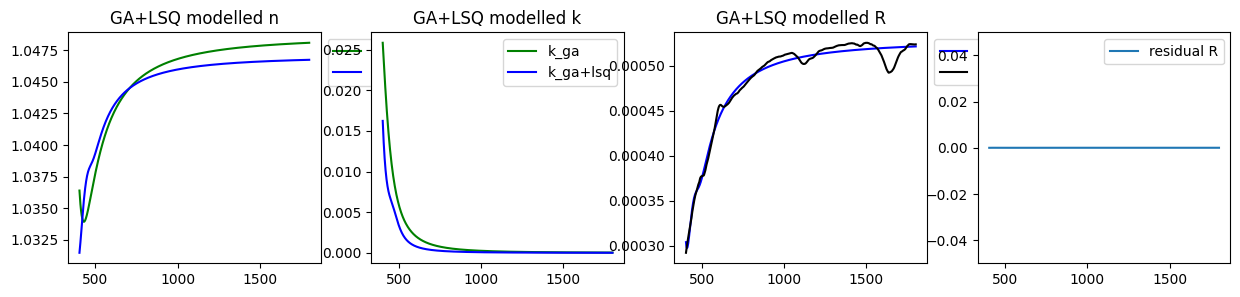

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


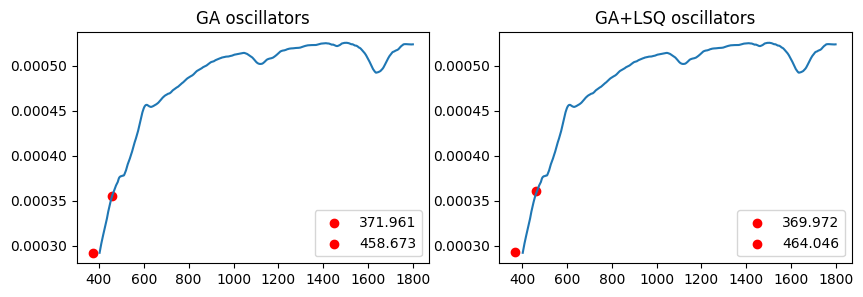

  1%|▏         | 140/10000 [00:09<11:23, 14.42it/s]


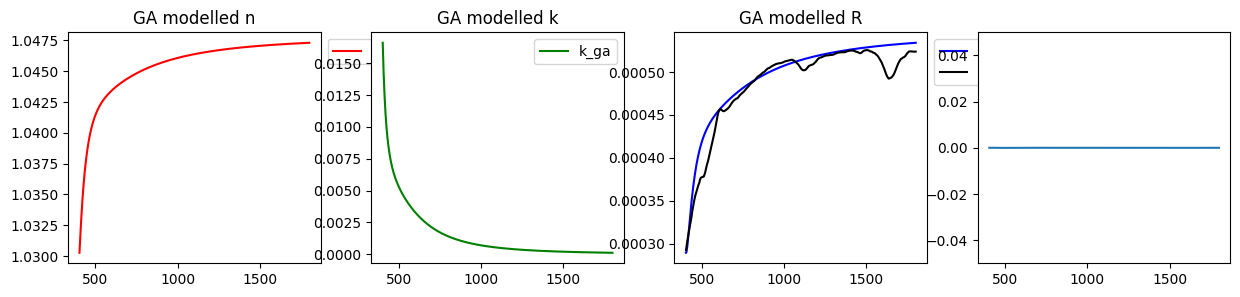

368.6359789018028	456.35437494257724	0.1059167223781361	1.1324190817900968	0.010369876760403463	0.011490193361813228	1.0980419618200137
Fitness value of the best solution = 100.0
Best fitness value reached after 40 generations.
Chi-square goodness of overall fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


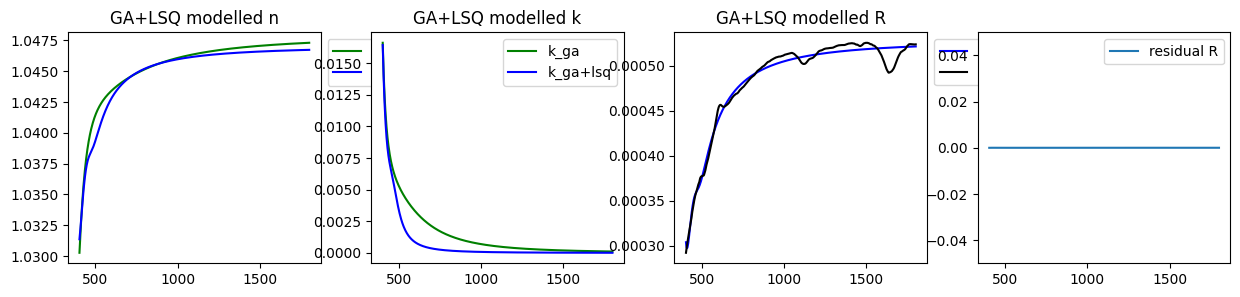

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


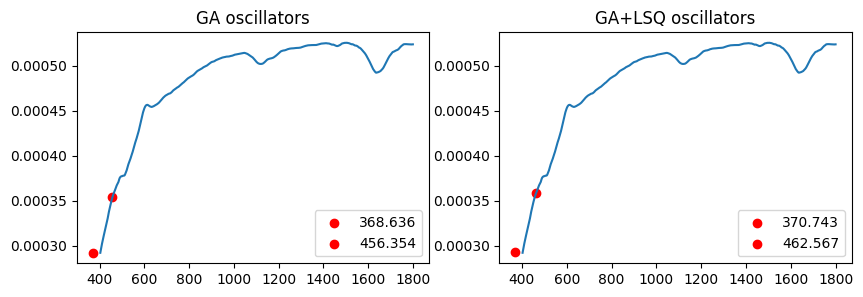

  2%|▏         | 194/10000 [00:14<12:29, 13.08it/s]


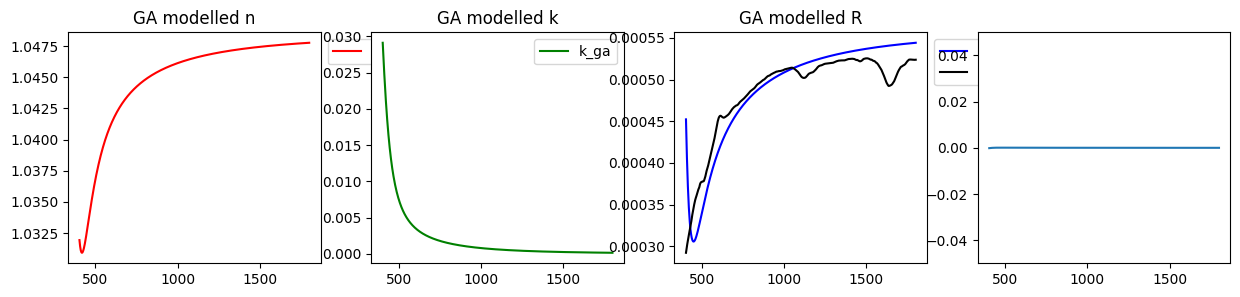

365.7481376925621	461.9750824459838	0.29286580388600325	1.7676739261761332	0.025361687542324374	0.00877500304295964	1.0994092750214697
Fitness value of the best solution = 99.9
Best fitness value reached after 94 generations.
Chi-square goodness of overall fitness is  0.001
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


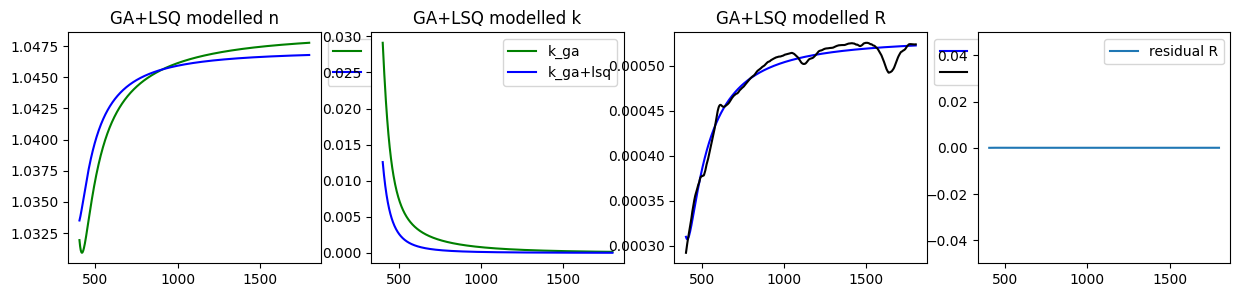

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


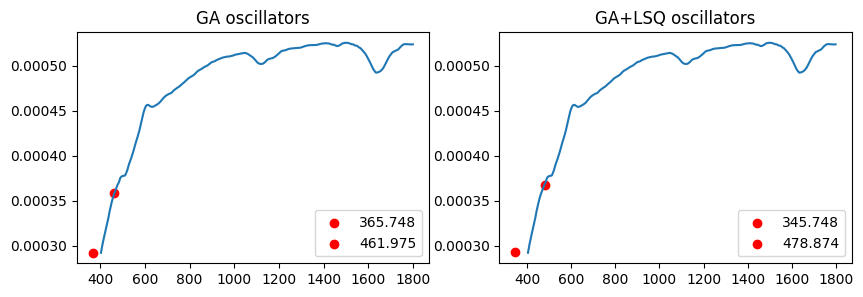

  1%|          | 113/10000 [00:07<10:33, 15.61it/s]


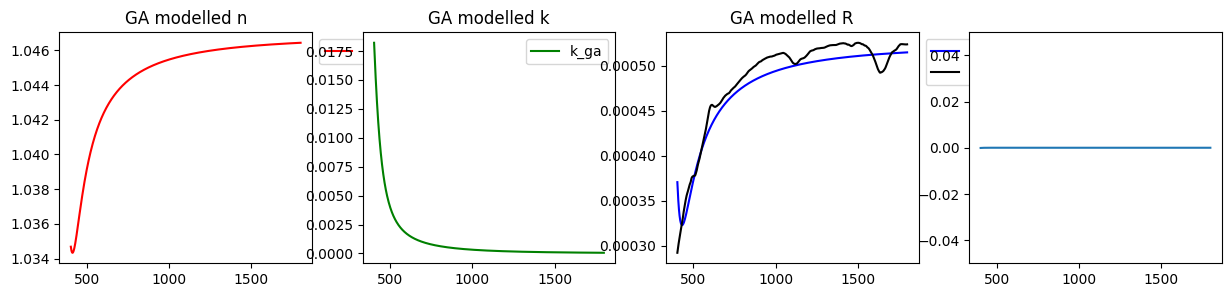

364.89610930035406	469.8274738258755	0.275009142466093	1.6719138296837082	0.016618669622715965	0.0026739411347056485	1.0958991132111684
Fitness value of the best solution = 100.0
Best fitness value reached after 13 generations.
Chi-square goodness of overall fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


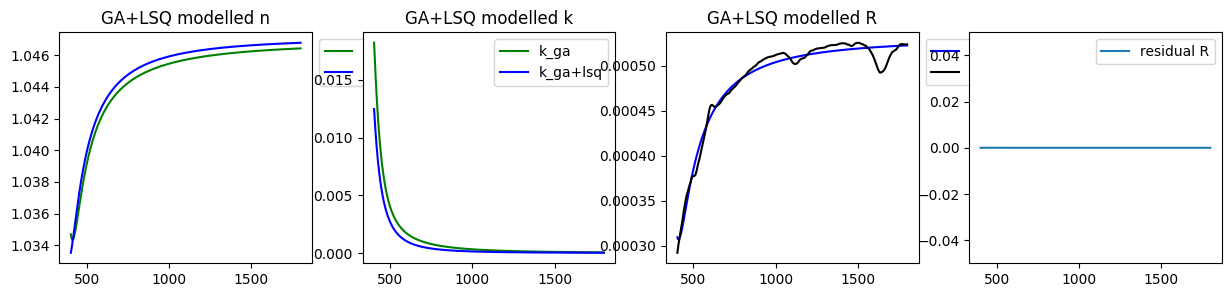

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


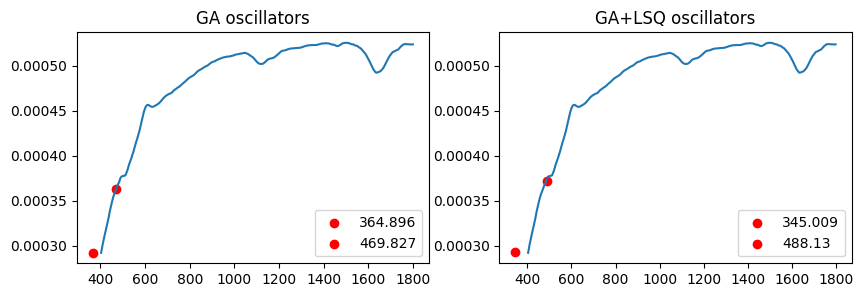

  2%|▏         | 167/10000 [00:12<12:01, 13.63it/s]


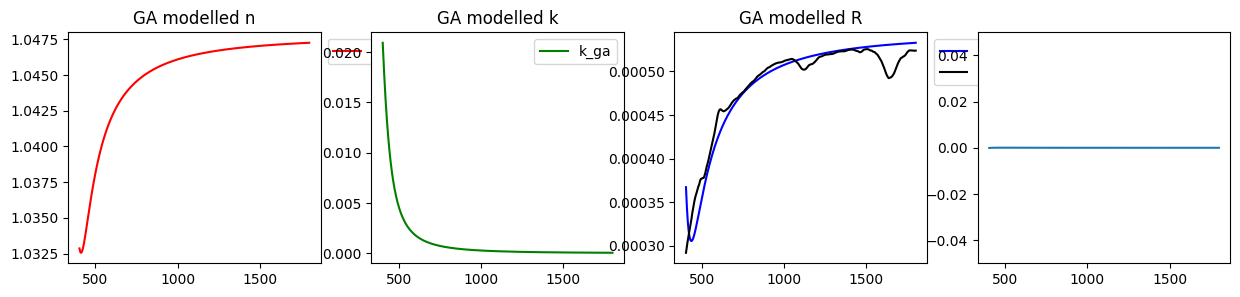

360.42683090632136	461.8947058151549	0.30249316150289496	1.685878054061248	0.02227265917891552	0.0010972860999518552	1.09773537087464
Fitness value of the best solution = 100.0
Best fitness value reached after 67 generations.
Chi-square goodness of overall fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


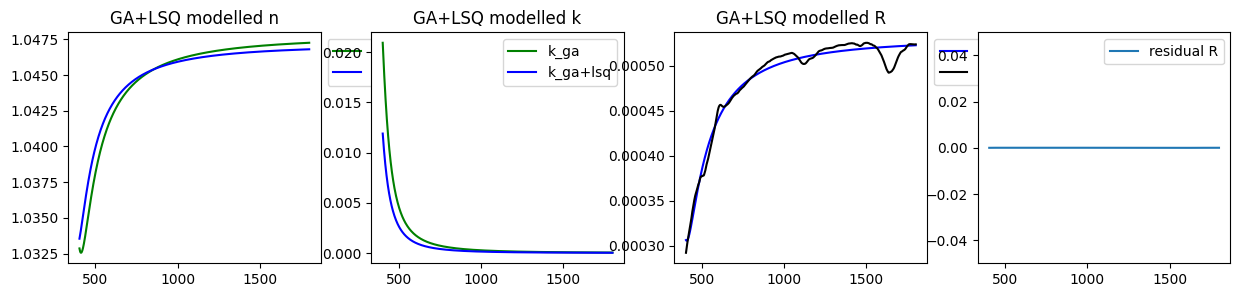

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


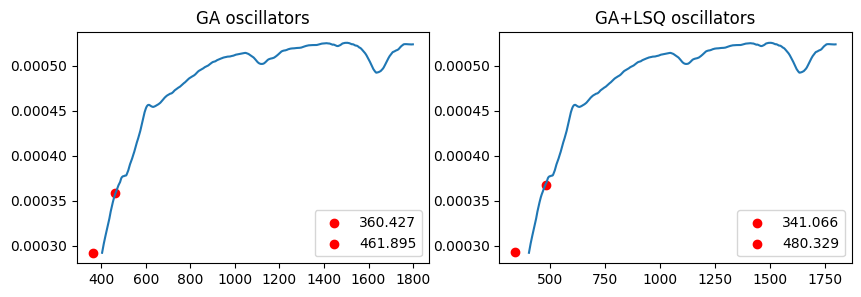

  1%|▏         | 146/10000 [00:10<11:51, 13.84it/s]


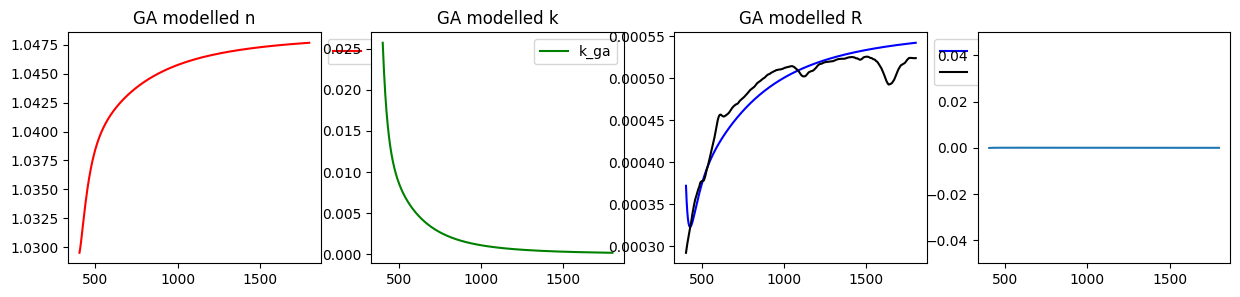

359.2159630411538	466.11803077090434	0.20279275725612433	1.1785103264492627	0.020097088448224776	0.01561706988454814	1.0994675639726077
Fitness value of the best solution = 100.0
Best fitness value reached after 46 generations.
Chi-square goodness of overall fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


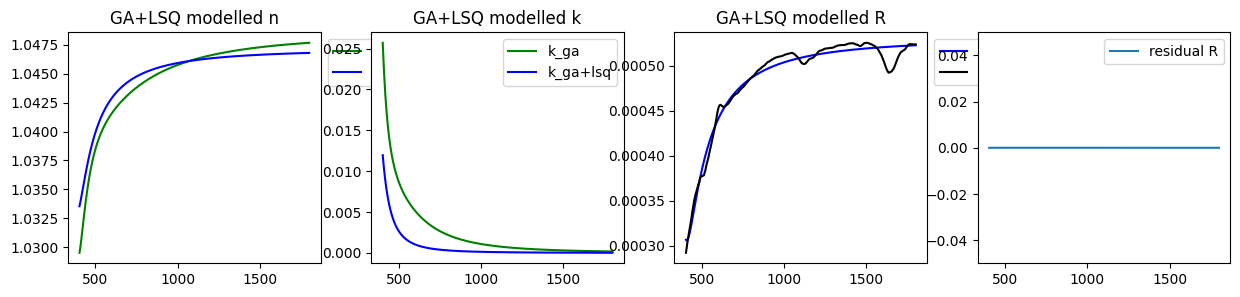

Chi-square goodness of fitness is  0.0
Chi-square goodness of R1 fitness is  0.0
Chi-square goodness of R2 fitness is  0.0
Chi-square goodness of R3 fitness is  0.0
Chi-square goodness of R4 fitness is  0.0
Chi-square goodness of R5 fitness is  0.0
Chi-square goodness of R6 fitness is  0.0


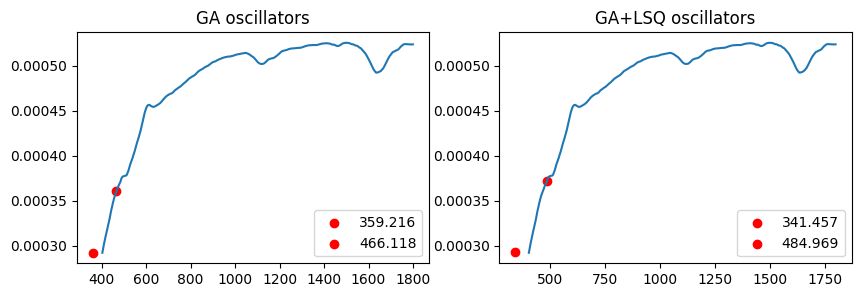

In [29]:
def count(sett, rangee):
    c=0   
    for val in sett:
        if  rangee[0] < val < rangee[-1]:
            c+=1       
    return c


ga_R_mod = {}
ga_R_res = {}
ga_n = {}
ga_k = {}


ga_lsq_R_mod = {}
ga_lsq_R_res = {}
ga_lsq_n = {}
ga_lsq_k = {}

lst_folders = ['best_solution_fitness', 'optical_constants', 'oscillation_params']

for lf in lst_folders:
    if os.path.isdir(lf):
        shutil.rmtree(lf)
        os.mkdir(lf)
    else:
        os.mkdir(lf)
        

max_num_oscillators_R1 = 1
max_num_oscillators_R2 = 5
max_num_oscillators_R3 = 5
max_num_oscillators_R4 = 1 
max_num_oscillators_R5 = 5 
max_num_oscillators_R6 = 0 

osc2 = 1
num_oscillators =2 
total_num_oscillators = max_num_oscillators_R1 + max_num_oscillators_R2 + max_num_oscillators_R3 + max_num_oscillators_R4 + max_num_oscillators_R5 + max_num_oscillators_R6


run = 1

while num_oscillators < total_num_oscillators:    
    if osc2 == 1:
        lb_ga_nu = np.repeat(420,num_oscillators)
        ub_ga_nu = np.repeat(1300,num_oscillators)
        osc2 = 0
        
    else:
        lb_ga_nu = ga_solution[:num_oscillators]-10.
        ub_ga_nu = ga_solution[:num_oscillators]+10.

        if chisq_val_R1 >= 0.03:
            lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R1']][0]+10)
            ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R1']][-1]-10)      

        if chisq_val_R2 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R2']]) < max_num_oscillators_R2:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R2']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R2']][-1]-10)      

        if chisq_val_R3 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R3']]) < max_num_oscillators_R3:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R3']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R3']][-1]-10)
            
        if chisq_val_R4 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R4']]) < max_num_oscillators_R4:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R4']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R4']][-1]-10)      

        if chisq_val_R5 >= 0.005:
            if count(ga_solution[:num_oscillators], v[spectra_range['R5']]) < max_num_oscillators_R5:
                lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R5']][0]+10)
                ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R5']][-1]-10)  
            
#         if chisq_val_R6 >= 0.05:
#             if count(ga_solution[:num_oscillators], v[spectra_range['R6']]) < max_num_oscillators_R6:
#                 lb_ga_nu = np.append(lb_ga_nu, v[spectra_range['R6']][0]+10)
#                 ub_ga_nu = np.append(ub_ga_nu, v[spectra_range['R6']][-1]-50) 

    
    num_oscillators = len(lb_ga_nu)
    
    lb_ga_nu = np.sort(lb_ga_nu)
    ub_ga_nu = np.sort(ub_ga_nu)

    lb_ga_gamm = np.repeat(0, num_oscillators)
    ub_ga_gamm = np.repeat(2, num_oscillators)

    lb_ga_fourpr = np.repeat(0, num_oscillators)
    ub_ga_fourpr = np.repeat(2, num_oscillators)

    lb_ga = np.hstack((lb_ga_nu, lb_ga_gamm, lb_ga_fourpr)) #lower bound of genes representing gamm, fourpr
    ub_ga = np.hstack((ub_ga_nu, ub_ga_gamm, ub_ga_fourpr)) #upper bound of genes representing gamm, fourpr

    gene_space = []
    for i in np.arange(len(lb_ga)):
        gene_space.append({'low': lb_ga[i], 'high': ub_ga[i]})
    gene_space.append({'low':1, 'high':4})


    ga_instance = ga_optical_constants(gene_space)
    ga_solution, ga_solution_fitness, ga_solution_idx = ga_instance.best_solution()
#     ga_instance.plot_fitness()

    R_ga,n_ga,k_ga = calculate_rnk(ga_solution, v, viewing_angle)


    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].plot(v,n_ga,'r', label='n_ga')
    ax[0].legend(bbox_to_anchor=(1,1))
    ax[0].set_title('GA modelled n')

    ax[1].plot(v,k_ga,'g', label='k_ga')
    ax[1].legend(bbox_to_anchor=(1,1))
    ax[1].set_title('GA modelled k')

    ax[2].plot(v,R_ga,'b', label='R_ga')
    ax[2].plot(v,R_smoothed,'k', label='R')
    ax[2].legend(bbox_to_anchor=(1,1))
    ax[2].set_title('GA modelled R')  

    ax[3].plot(v, R_smoothed-R_ga, label='residual R')
    ax[3].set_ylim(-0.05, +0.05)
    plt.show()

    print("\t".join(map(str, ga_solution)))
    

    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=ga_solution_fitness))

    if ga_instance.best_solution_generation != -1:
        print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

    chisq_val = chisq(R_ga, R_smoothed)
    print("Chi-square goodness of overall fitness is ", chisq_val)

    chisq_val_R1 = chisq(R_ga[spectra_range['R1']], R_smoothed[spectra_range['R1']])
    chisq_val_R2 = chisq(R_ga[spectra_range['R2']], R_smoothed[spectra_range['R2']])
    chisq_val_R3 = chisq(R_ga[spectra_range['R3']], R_smoothed[spectra_range['R3']])
    chisq_val_R4 = chisq(R_ga[spectra_range['R4']], R_smoothed[spectra_range['R4']])
    chisq_val_R5 = chisq(R_ga[spectra_range['R5']], R_smoothed[spectra_range['R5']])
    chisq_val_R6 = chisq(R_ga[spectra_range['R6']], R_smoothed[spectra_range['R6']])
    
    print("Chi-square goodness of R1 fitness is ", chisq_val_R1)
    print("Chi-square goodness of R2 fitness is ", chisq_val_R2)
    print("Chi-square goodness of R3 fitness is ", chisq_val_R3)
    print("Chi-square goodness of R4 fitness is ", chisq_val_R4)
    print("Chi-square goodness of R5 fitness is ", chisq_val_R5)
    print("Chi-square goodness of R6 fitness is ", chisq_val_R6)
    

#     np.savetxt('oscillation_parameters_new.txt', ga_solution)
    np.savetxt('oscillation_params/run%s_%s_NumOfOscillators_ga_oscillation_parameters.txt'%(run, num_oscillators), ga_solution)
    np.savetxt("oscillation_params/run%s_%s_NumOfOscillators_ga_chi_sq.txt"%(run, num_oscillators), np.stack((chisq_val, chisq_val_R1, chisq_val_R2, chisq_val_R3, chisq_val_R4, chisq_val_R5, chisq_val_R6)), header="overall_chisq, R1_chisq, R2_chisq, R3_chisq, R4_chisq, R5_chisq, R6_chisq")
    np.savetxt("optical_constants/run%s_%s_NumOfOscillators_ga_optical_constants.txt"%(run, num_oscillators), np.stack((v, R_ga, R_smoothed-R_ga, n_ga, k_ga), axis=1), header="wavenumber, R_modelled, R_residuals, n , k")
    np.savetxt('best_solution_fitness/run%s_%s_NumOfOscillators_ga_best_solution_fitness_per_generation.txt'%(run, num_oscillators), ga_instance.best_solutions_fitness)
    
    
    
    ga_oscillation_parameters = np.copy(ga_solution)

    N = int((len(ga_oscillation_parameters)-1)/3)

    nu=ga_oscillation_parameters[0:N]
    gamm=ga_oscillation_parameters[N:N+N]
    fourpr=ga_oscillation_parameters[N+N:N+N+N]
    epsil=ga_oscillation_parameters[N+N+N] 

    ga_oscillators_initial = np.hstack((nu,gamm,fourpr,epsil))

    # gamm=gamm./nu;
    # fourpr=Sk./(nu.^2);

    # Set lower and upper bounds
    lb_nu=-20.+nu
    ub_nu=20.+nu
    lb_gamm=np.zeros((1,len(nu)))
    ub_gamm=np.tile(4,(1,len(nu)))
    lb_fourpr=np.zeros((1,len(nu)))
    ub_fourpr=np.tile(4,(1,len(nu)))


    lb=np.hstack((lb_nu,lb_gamm.flatten(),lb_fourpr.flatten(),1))
    ub=np.hstack((ub_nu,ub_gamm.flatten(),ub_fourpr.flatten(),4))

    ga_oscillators_final, lsq_cov = curve_fit(func_lsq_R, xdata=v, p0=ga_oscillators_initial, ydata=R_smoothed, bounds=(lb,ub), maxfev=10000)

    R_final, n_final, k_final = calculate_rnk(ga_oscillators_final,v, viewing_angle)
    
    N = int((len(ga_oscillators_final)-1)/3)

    nu=ga_oscillators_final[0:N]
    gamm=ga_oscillators_final[N:N+N]
    fourpr=ga_oscillators_final[N+N:N+N+N]
    epsil=ga_oscillators_final[N+N+N] 
    

    fig, ax = plt.subplots(1,4, figsize=(15, 3))
    ax[0].plot(v, n_ga, 'g', label='n_ga')
    ax[0].plot(v, n_final, 'b', label='n_ga+lsq')
    ax[0].legend(bbox_to_anchor=(1,1))
    ax[0].set_title('GA+LSQ modelled n')

    ax[1].plot(v,k_ga,'g', label='k_ga')
    ax[1].plot(v,k_final,'b', label='k_ga+lsq')
    ax[1].legend(bbox_to_anchor=(1,1))
    ax[1].set_title('GA+LSQ modelled k')

    ax[2].plot(v,R_final,'b', label='R_ga+lsq')
    ax[2].plot(v,R_smoothed,'k', label='R')
    ax[2].legend(bbox_to_anchor=(1,1))
    ax[2].set_title('GA+LSQ modelled R')  

    ax[3].plot(v, R_smoothed-R_final, label='residual R')
    ax[3].set_ylim(-0.05, +0.05)
    plt.legend()
    plt.show()

    chisq_val = chisq(R_final[1:], R_smoothed[1:])

    print("Chi-square goodness of fitness is ", chisq_val)

    chisq_val_R1 = chisq(R_final[spectra_range['R1']], R_smoothed[spectra_range['R1']])
    chisq_val_R2 = chisq(R_final[spectra_range['R2']], R_smoothed[spectra_range['R2']])
    chisq_val_R3 = chisq(R_final[spectra_range['R3']], R_smoothed[spectra_range['R3']])
    chisq_val_R4 = chisq(R_final[spectra_range['R4']], R_smoothed[spectra_range['R4']])
    chisq_val_R5 = chisq(R_final[spectra_range['R5']], R_smoothed[spectra_range['R5']])
    chisq_val_R6 = chisq(R_final[spectra_range['R6']], R_smoothed[spectra_range['R6']])
    
    print("Chi-square goodness of R1 fitness is ", chisq_val_R1)
    print("Chi-square goodness of R2 fitness is ", chisq_val_R2)
    print("Chi-square goodness of R3 fitness is ", chisq_val_R3)
    print("Chi-square goodness of R4 fitness is ", chisq_val_R4)
    print("Chi-square goodness of R5 fitness is ", chisq_val_R5)
    print("Chi-square goodness of R6 fitness is ", chisq_val_R6)
    
    
    fig, ax2 = plt.subplots(1,2, figsize=(10, 3))

    ax2[0].plot(v,R_smoothed)
    for i in ga_solution[:num_oscillators]:
        ax2[0].scatter(i, R_smoothed[np.abs(v-i).argmin()], label=round(i,3), color='r')
    ax2[0].legend()
    ax2[0].set_title("GA oscillators")

    ax2[1].plot(v,R_smoothed)
    for i in ga_oscillators_final[:num_oscillators]:
        ax2[1].scatter(i, R[np.abs(v-i).argmin()], label=round(i,3), color='r')
    ax2[1].legend()
    ax2[1].set_title("GA+LSQ oscillators")
    plt.show()

    

    R_residuals = R_smoothed-R_final
    
    np.savetxt('oscillation_params/run%s_%s_NumOfOscillators_lsq_oscillation_parameters.txt'%(run, num_oscillators), ga_oscillators_final)
    np.savetxt("optical_constants/run%s_%s_NumOfOscillators_lsq_optical_constants.txt"%(run, num_oscillators), np.stack((v, R_final, R_residuals, n_final, k_final), axis=1), header="wavenumber, R_modelled, R_residuals, n , k")
    np.savetxt("oscillation_params/run%s_%s_NumOfOscillators_lsq_chi_sq.txt"%(run, num_oscillators), np.stack((chisq_val, chisq_val_R1, chisq_val_R2, chisq_val_R3, chisq_val_R4, chisq_val_R5, chisq_val_R6)), header="overall_chisq, R1_chisq, R2_chisq, R3_chisq, R4_chisq, R5_chisq, R6_chisq")
    
    run+=1
    
    if (N>=total_num_oscillators) or (run>=total_num_oscillators):
        break




In [30]:
import numpy as np

def calculate_averages(file_path):
    # Initialize lists for data
    data = []

    # Read the file and extract data
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or not line.strip():
                continue
            values = [float(val) for val in line.split()]
            if len(values) == 5:  # Ensure there are 5 columns
                data.append(values)

    # Convert to a numpy array for easy calculations
    data = np.array(data)
    
    # Calculate and print averages
    if data.size > 0:
        for i, column_average in enumerate(np.mean(data, axis=0)):
            print(f"Average of column {i+1}: {column_average}")
    else:
        print("No data to calculate averages.")

# Example usage
file_path = r'C:\Users\maril\Downloads\HAPKE_MIXING-master\HAPKE_MIXING-master\optical_constants\run16_2_NumOfOscillators_lsq_optical_constants.txt'
calculate_averages(file_path)


Average of column 1: 1101.1544881379311
Average of column 2: 0.00048701920524563445
Average of column 3: -7.655932871723266e-10
Average of column 4: 1.0450220570983377
Average of column 5: 0.0006742402062111578
